# Plot with Index Number

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tta.data.cifar import Cifar10CDataset
from tta.data.dataloader import build_test_loader
from tta.method.source import Source

method = Source()
model = method.model
device = "mps"

entropy_values_per = {}
gradient_norms_per = {}
cross_entropy_values_per = {}

for i, c in enumerate(["gaussian_noise", "brightness"]):
    dataset = Cifar10CDataset(num_samples=100, corrupt_domain_orders=[c], severity=5)
    data_loader = build_test_loader(dataset, batch_size=1)

    # Assume you have a trained model and some input data
    model.eval()

    entropy_values = []
    gradient_norms = []
    cross_entropy_values = []
    for batch in data_loader:  # single sample or batch size = 1
        input_sample, label, _ = batch
        input_sample = input_sample.to(device).requires_grad_(True)

        # Forward pass
        output = model(input_sample)
        probs = F.softmax(output, dim=1)

        # Compute entropy
        log_probs = torch.log(probs + 1e-12)
        entropy = -torch.sum(probs * log_probs, dim=1)  # entropy per sample
        entropy_values.append(entropy.item())

        # Use entropy (or max logit) as pseudo-loss to compute gradients
        pseudo_loss = entropy.sum()
        pseudo_loss.backward(retain_graph=True)

        # Compute gradient norm w.r.t. input
        grad = input_sample.grad.detach()
        grad_norm = torch.norm(grad, p=2)  # L2 norm
        gradient_norms.append(grad_norm.item())

        # Compute cross-entropy loss
        cross_entropy_loss = F.cross_entropy(output, label.to(device))
        cross_entropy_values.append(cross_entropy_loss.item())
        model.zero_grad()
    entropy_values_per[i] = entropy_values
    gradient_norms_per[i] = gradient_norms
    cross_entropy_values_per[i] = cross_entropy_values

/Users/jongseob.jeon/workspace/projects/production_lab/test-time-adaptation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jongseob.jeon/workspace/projects/production_lab/test-time-adaptation/.venv/lib/python3.11/site-packages/robustbench/utils.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to b

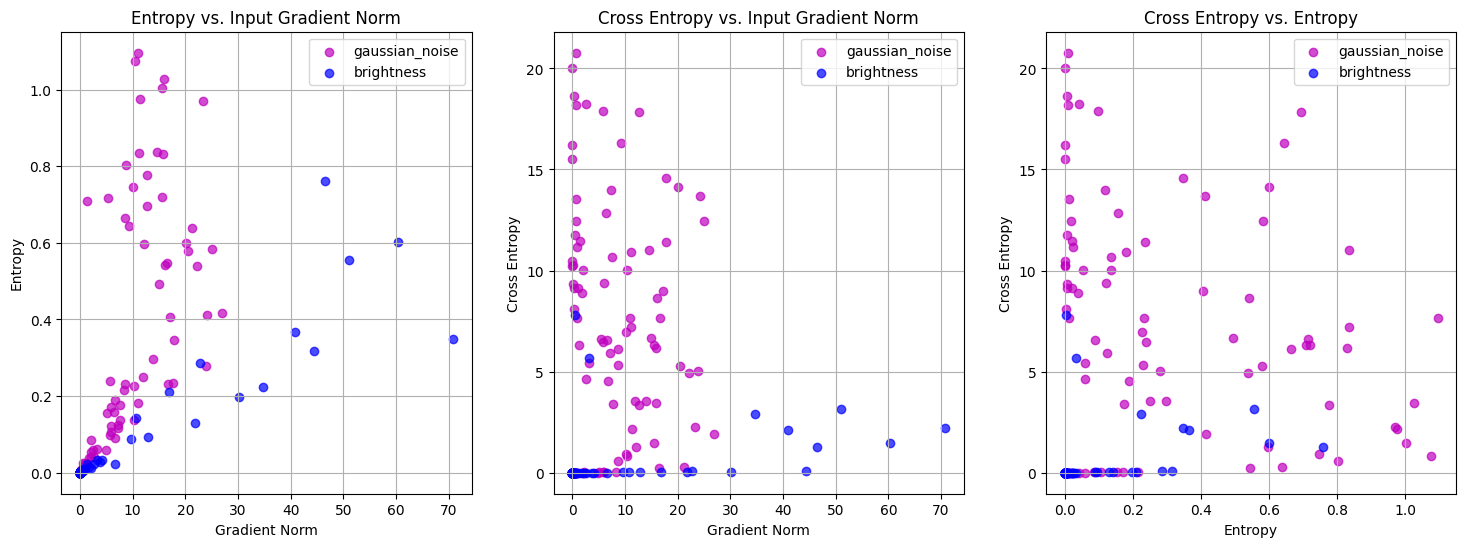

In [ ]:
colors = ["b", "g", "r", "c", "m"]  # Define a list of colors for different values of i

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

for i in range(2):
    axes[0].scatter(
        gradient_norms_per[i],
        entropy_values_per[i],
        color=colors[i - 1],
        label=["gaussian_noise", "brightness"][i],
        alpha=0.7,
    )

axes[0].set_xlabel("Gradient Norm")
axes[0].set_ylabel("Entropy")

axes[0].set_title("Entropy vs. Input Gradient Norm")
axes[0].legend()
axes[0].grid(True)


for i in range(2):
    axes[1].scatter(
        gradient_norms_per[i],
        cross_entropy_values_per[i],
        color=colors[i - 1],
        label=["gaussian_noise", "brightness"][i],
        alpha=0.7,
    )

axes[1].set_xlabel("Gradient Norm")
axes[1].set_ylabel("Cross Entropy")

axes[1].set_title("Cross Entropy vs. Input Gradient Norm")
axes[1].legend()
axes[1].grid(True)


for i in range(2):
    axes[2].scatter(
        entropy_values_per[i],
        cross_entropy_values_per[i],
        color=colors[i - 1],
        label=["gaussian_noise", "brightness"][i],
        alpha=0.7,
    )

axes[2].set_xlabel("Entropy")
axes[2].set_ylabel("Cross Entropy")

axes[2].set_title("Cross Entropy vs. Entropy")
axes[2].legend()
axes[2].grid(True)

plt.show()

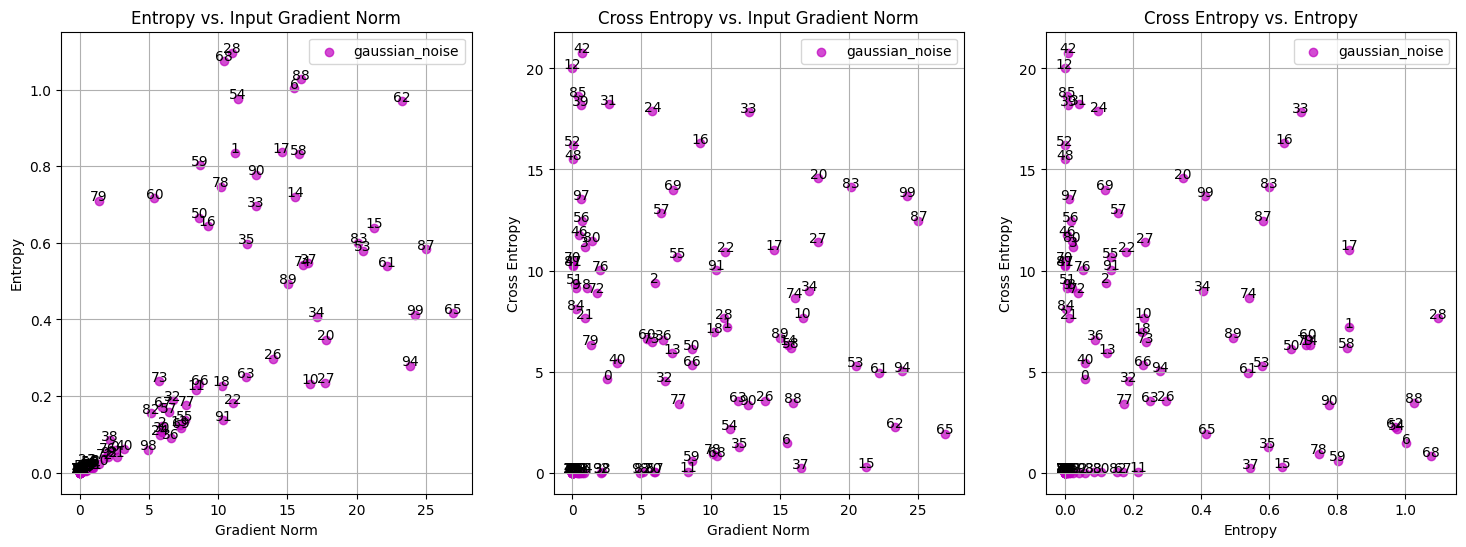

In [3]:
colors = ["b", "g", "r", "c", "m"]  # Define a list of colors for different values of i

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
idx = 0
gradient_norms_sole = gradient_norms_per[idx]
entropy_values_sole = entropy_values_per[idx]
cross_entropy_values_sole = cross_entropy_values_per[idx]
label = ["gaussian_noise", "brightness"][idx]


axes[0].scatter(
    gradient_norms_sole,
    entropy_values_sole,
    color=colors[idx - 1],
    label=label,
    alpha=0.7,
)

for i in range(len(gradient_norms_sole)):
    axes[0].annotate(
        f"{i}",
        (gradient_norms_sole[i], entropy_values_sole[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

axes[0].set_xlabel("Gradient Norm")
axes[0].set_ylabel("Entropy")

axes[0].set_title("Entropy vs. Input Gradient Norm")
axes[0].legend()
axes[0].grid(True)


axes[1].scatter(
    gradient_norms_sole,
    cross_entropy_values_sole,
    color=colors[idx - 1],
    label=label,
    alpha=0.7,
)

for i in range(len(gradient_norms_sole)):
    axes[1].annotate(
        f"{i}",
        (gradient_norms_sole[i], cross_entropy_values_sole[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

axes[1].set_xlabel("Gradient Norm")
axes[1].set_ylabel("Cross Entropy")

axes[1].set_title("Cross Entropy vs. Input Gradient Norm")
axes[1].legend()
axes[1].grid(True)


axes[2].scatter(
    entropy_values_sole,
    cross_entropy_values_sole,
    color=colors[idx - 1],
    label=label,
    alpha=0.7,
)

for i in range(len(entropy_values)):
    axes[2].annotate(
        f"{i}",
        (entropy_values_sole[i], cross_entropy_values_sole[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

axes[2].set_xlabel("Entropy")
axes[2].set_ylabel("Cross Entropy")

axes[2].set_title("Cross Entropy vs. Entropy")
axes[2].legend()
axes[2].grid(True)

plt.show()

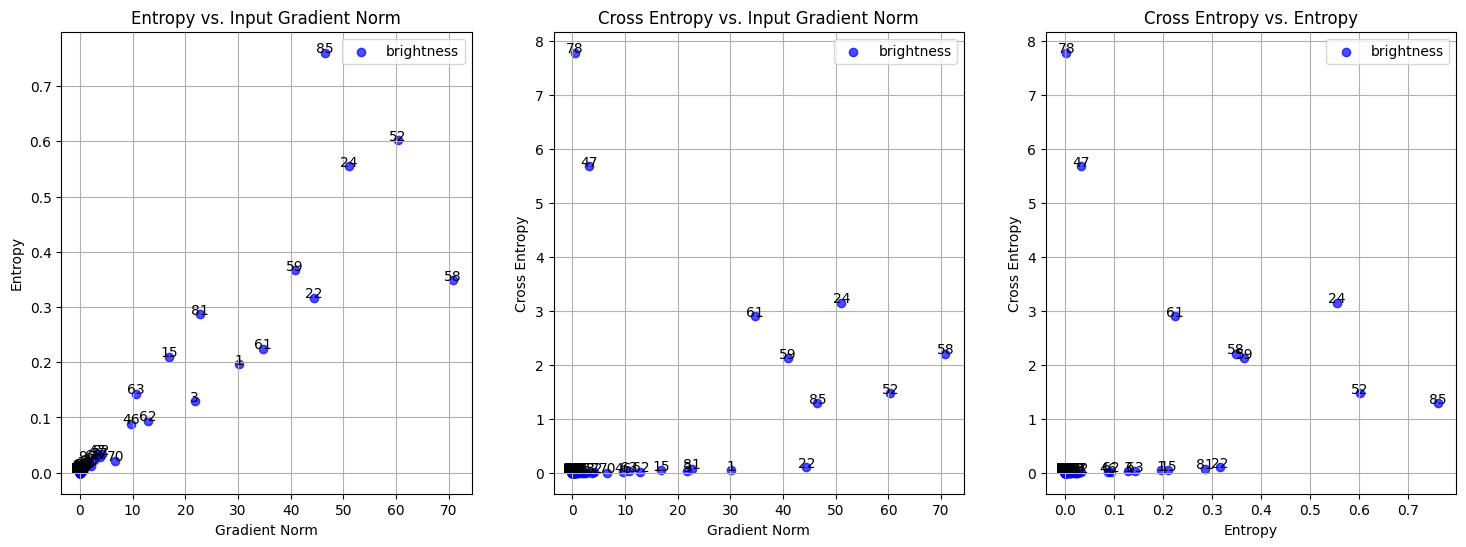

In [4]:
colors = ["b", "g", "r", "c", "m"]  # Define a list of colors for different values of i

fig, axes = plt.subplots(ncols=3, figsize=(18, 6))
idx = 1
gradient_norms_sole = gradient_norms_per[idx]
entropy_values_sole = entropy_values_per[idx]
cross_entropy_values_sole = cross_entropy_values_per[idx]
label = ["gaussian_noise", "brightness"][idx]


axes[0].scatter(
    gradient_norms_sole,
    entropy_values_sole,
    color=colors[idx - 1],
    label=label,
    alpha=0.7,
)

for i in range(len(gradient_norms_sole)):
    axes[0].annotate(
        f"{i}",
        (gradient_norms_sole[i], entropy_values_sole[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

axes[0].set_xlabel("Gradient Norm")
axes[0].set_ylabel("Entropy")

axes[0].set_title("Entropy vs. Input Gradient Norm")
axes[0].legend()
axes[0].grid(True)


axes[1].scatter(
    gradient_norms_sole,
    cross_entropy_values_sole,
    color=colors[idx - 1],
    label=label,
    alpha=0.7,
)

for i in range(len(gradient_norms_sole)):
    axes[1].annotate(
        f"{i}",
        (gradient_norms_sole[i], cross_entropy_values_sole[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

axes[1].set_xlabel("Gradient Norm")
axes[1].set_ylabel("Cross Entropy")

axes[1].set_title("Cross Entropy vs. Input Gradient Norm")
axes[1].legend()
axes[1].grid(True)


axes[2].scatter(
    entropy_values_sole,
    cross_entropy_values_sole,
    color=colors[idx - 1],
    label=label,
    alpha=0.7,
)

for i in range(len(entropy_values)):
    axes[2].annotate(
        f"{i}",
        (entropy_values_sole[i], cross_entropy_values_sole[i]),
        textcoords="offset points",
        xytext=(0, 0),
        ha="center",
    )

axes[2].set_xlabel("Entropy")
axes[2].set_ylabel("Cross Entropy")

axes[2].set_title("Cross Entropy vs. Entropy")
axes[2].legend()
axes[2].grid(True)

plt.show()